In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Data Load

In [2]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append("/content/drive/MyDrive/Colab Notebooks")

train_path = '/content/drive/MyDrive/Colab Notebooks/data/AB_NYC_2019.csv'

Mounted at /content/drive


# Data Preprocessing

In [3]:
# haversine fuction
def haversine(lat1, lon1, lat2, lon2):
    R = 6371
    φ1, φ2 = np.radians(lat1), np.radians(lat2)
    Δφ = φ2 - φ1
    Δλ = np.radians(lon2 - lon1)
    a = np.sin(Δφ/2)**2 + np.cos(φ1)*np.cos(φ2)*np.sin(Δλ/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R * c

In [4]:
df = pd.read_csv(train_path)
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [5]:
df.drop(columns=['id', 'name', 'host_id', 'host_name', 'neighbourhood'], inplace=True)

In [6]:
df=pd.get_dummies(df,columns=['neighbourhood_group'])
# df.head()

In [7]:
dummy_cols = [col for col in df.columns if col.startswith('neighbourhood_group_')]

#center latitude, longitude of each location
centers = {
    'neighbourhood_group_Bronx': (40.8448, -73.8648),
    'neighbourhood_group_Brooklyn': (40.6782, -73.9442),
    'neighbourhood_group_Manhattan': (40.7685, -73.9822),
    'neighbourhood_group_Queens': (40.7282, -73.7949),
    'neighbourhood_group_Staten Island': (40.5795, -74.1502),
}

#After examining the one-hot encoded t,f value of each row, find which sphere corresponds to and return-
#-the distance between the latitude longitude of the row and the latitude longitude of the center of the row
#shows at one column(feature)
def compute_distance(row):
    for col in dummy_cols:
        if row.get(col, False):
            clat, clon = centers[col]
            return haversine(row['latitude'], row['longitude'], clat, clon)
    return np.nan

df['distance_to_center'] = df.apply(compute_distance, axis=1)

# df.head()

In [8]:
# Calculate review date differences (smaller value in recent days)
reference_date = pd.to_datetime("2019-12-01")
df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')
df['days_since_oldest_review'] = (reference_date - df['last_review']).dt.days

# Missing value processing: no review → considered older than the oldest value max + 30
temp_days = df['days_since_oldest_review'].copy()
df['days_since_oldest_review'] = temp_days.fillna(temp_days.max() + 30)

# Transform to be more recent
max_days = df['days_since_oldest_review'].max()
df['days_since_oldest_review'] = max_days - df['days_since_oldest_review']
df.drop(columns=['last_review'], inplace=True)

df[['days_since_oldest_review']].head()

,days_since_oldest_review
0,2792.0
1,3006.0
2,0.0
3,3051.0
4,2823.0


In [9]:
#room type one-hot encoding
df['reviews_per_month'].fillna(0, inplace=True)
df=pd.get_dummies(df,columns=['room_type'])
df.head()

<ipython-input-9-a01b5b298c0c>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['reviews_per_month'].fillna(0, inplace=True)


,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,distance_to_center,days_since_oldest_review,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
0,40.64749,-73.97237,149,1,9,0.21,6,365,False,True,False,False,False,4.160116,2792.0,False,True,False
1,40.75362,-73.98377,225,1,45,0.38,2,355,False,False,True,False,False,1.659856,3006.0,True,False,False
2,40.80902,-73.94190,150,3,0,0.00,1,365,False,False,True,False,False,5.640177,0.0,False,True,False
3,40.68514,-73.95976,89,1,270,4.64,1,194,False,True,False,False,False,1.522190,3051.0,True,False,False
4,40.79851,-73.94399,80,10,9,0.10,1,0,False,False,True,False,False,4.635187,2823.0,True,False,False


In [10]:
df.drop(columns=['latitude', 'longitude'], inplace=True)
df

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,distance_to_center,days_since_oldest_review,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
0,149,1,9,0.21,6,365,False,True,False,False,False,4.160116,2792.0,False,True,False
1,225,1,45,0.38,2,355,False,False,True,False,False,1.659856,3006.0,True,False,False
2,150,3,0,0.00,1,365,False,False,True,False,False,5.640177,0.0,False,True,False
3,89,1,270,4.64,1,194,False,True,False,False,False,1.522190,3051.0,True,False,False
4,80,10,9,0.10,1,0,False,False,True,False,False,4.635187,2823.0,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48890,70,2,0,0.00,2,9,False,True,False,False,False,0.486273,0.0,False,True,False
48891,40,4,0,0.00,2,36,False,True,False,False,False,2.788305,0.0,False,True,False
48892,115,10,0,0.00,1,27,False,False,True,False,False,5.866492,0.0,True,False,False
48893,55,1,0,0.00,6,2,False,False,True,False,False,1.434483,0.0,False,False,True


In [11]:
# Columns to scale (all remaining columns in df now)
features = df.columns.tolist()

# StandardScaler apply
scaler = StandardScaler()
scaled_array = scaler.fit_transform(df[features].values)

# Rebuild to DataFrame
df_std = pd.DataFrame(scaled_array, columns=features, index=df.index)

# checking result
print(df_std.head())

      price  minimum_nights  number_of_reviews  reviews_per_month  \
0 -0.015493       -0.293996          -0.320414          -0.551511   
1  0.300974       -0.293996           0.487665          -0.445079   
2 -0.011329       -0.196484          -0.522433          -0.682986   
3 -0.265335       -0.293996           5.538156           2.221978   
4 -0.302811        0.144807          -0.320414          -0.620379   

   calculated_host_listings_count  availability_365  \
0                       -0.034716          1.916250   
1                       -0.156104          1.840275   
2                       -0.186451          1.916250   
3                       -0.186451          0.617065   
4                       -0.186451         -0.856865   

   neighbourhood_group_Bronx  neighbourhood_group_Brooklyn  \
0                  -0.151071                      1.196705   
1                  -0.151071                     -0.835628   
2                  -0.151071                     -0.835628   
3     

# Clustering

## Search for optimal k values

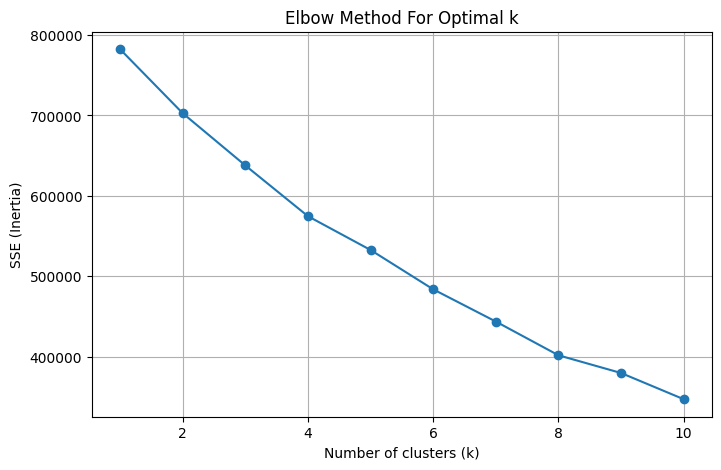

In [12]:
from sklearn.cluster import KMeans

df_standard = df_std.copy() # 원본 df_std를 유지하기 위해 copy() 사용
X_for_clustering = df_standard # 클러스터링을 위한 데이터

sse = []  # Sum of Squared Errors

# Perform KMeans by changing the K value from 1 to 10
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(X_for_clustering)
    sse.append(kmeans.inertia_)  # inertia_ == SSE

# present graph
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), sse, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('SSE (Inertia)')
plt.grid(True)
plt.show()


**Elbow is missing. **

-> Using the silhouette method

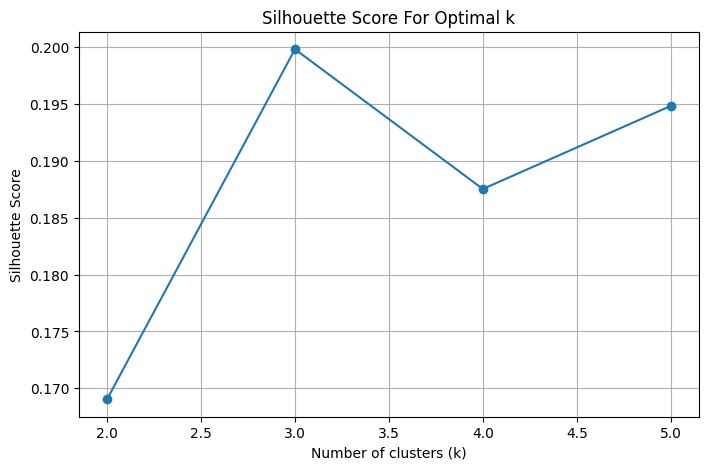

In [13]:
from sklearn.metrics import silhouette_score

# Use silhouette analysis to search for optimal K values
silhouette_scores = []
for k in range(2, 6):
    kmeans = KMeans(n_clusters=k, random_state=0, n_init='auto')
    kmeans.fit(X_for_clustering)
    score = silhouette_score(X_for_clustering, kmeans.labels_)
    silhouette_scores.append(score)

# present graph
plt.figure(figsize=(8, 5)) # 새로운 figure 생성
plt.plot(range(2, 6), silhouette_scores, marker='o')
plt.title('Silhouette Score For Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

## Clustering

In [14]:
# Cluster with K=3
kmeans = KMeans(n_clusters=3, random_state=0, n_init='auto') # n_init='auto' 추가
df_standard['cluster'] = kmeans.fit_predict(X_for_clustering) # 클러스터 라벨 추가

## Interpret cluster semantics

In [15]:
cluster_means = df_standard.groupby('cluster').mean(numeric_only=True)
print("\n--- Cluster Means ---")
print(cluster_means)


--- Cluster Means ---
            price  minimum_nights  number_of_reviews  reviews_per_month  \
cluster                                                                   
0       -0.140351       -0.065818           0.021894          -0.024995   
1        0.467000        0.231789          -0.129686          -0.152193   
2       -0.225578       -0.116962           0.084865           0.165539   

         calculated_host_listings_count  availability_365  \
cluster                                                     
0                             -0.148242         -0.098668   
1                              0.355421          0.046459   
2                             -0.117788          0.087758   

         neighbourhood_group_Bronx  neighbourhood_group_Brooklyn  \
cluster                                                            
0                        -0.151071                      1.196705   
1                        -0.136483                     -0.827172   
2                      

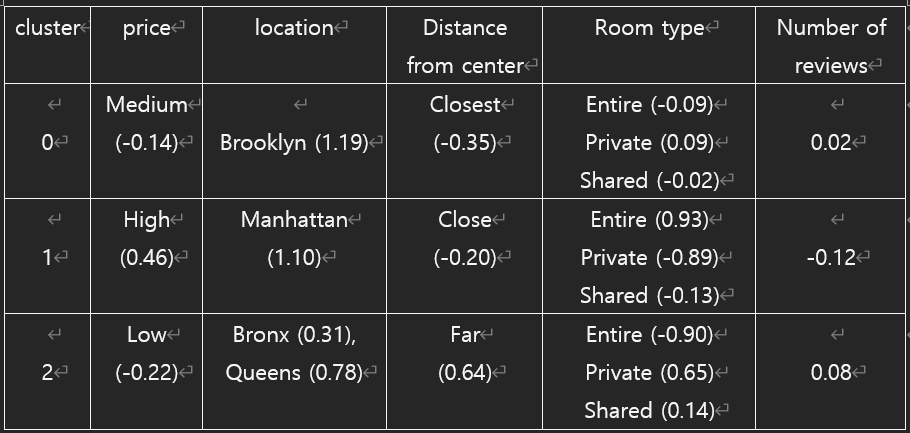

Cluster 0 : Practical  

Cluster 1: Premium  

Cluster 2: Low cost/outside  

In the case of cluster 0, there are many accommodations located in Brooklyn at a moderate price, and the distance from the center is close. Private rooms tend to be more than Entry home/apt and shared rooms.  

For cluster 1, there are many high-priced accommodations, most of which are located in Manhattan, and there are many Entire home/apt.  

In the case of cluster 2, the price is low and there are many accommodations located in Bronx and Queens. It is far from the center and there are many private and shared rooms.


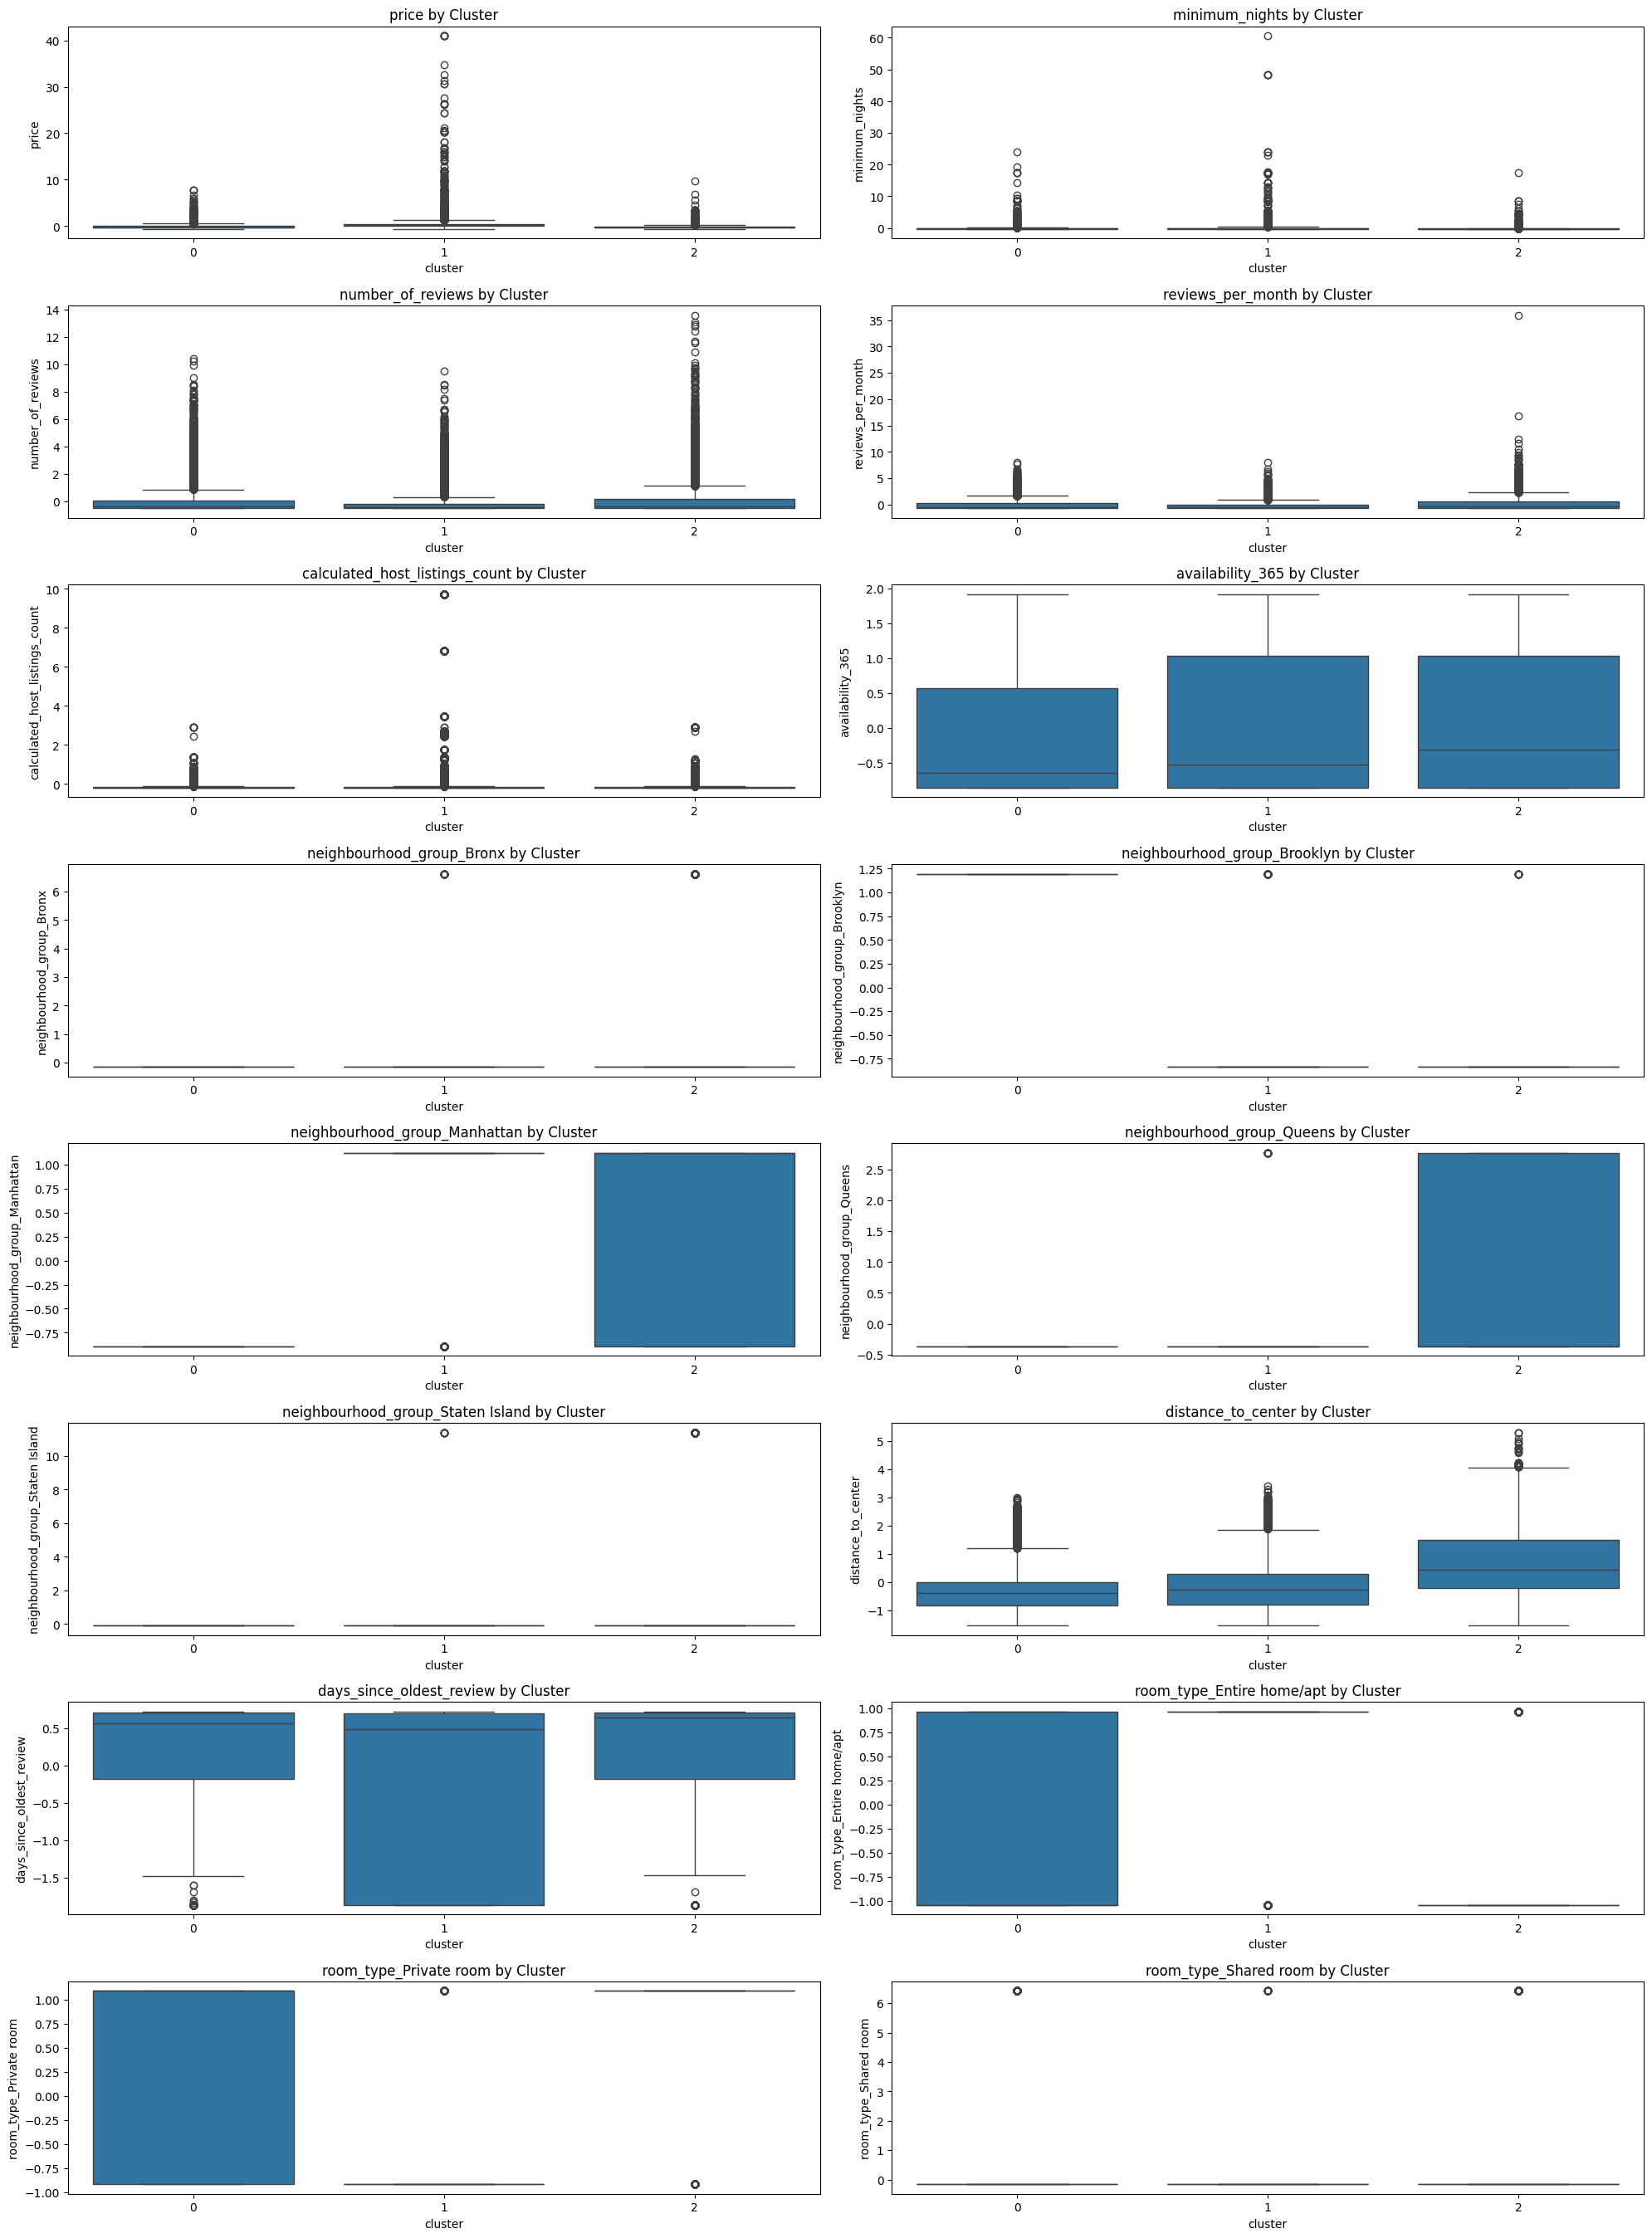

In [16]:
# Create boxplot based on df_scaled with cluster column
features_for_boxplot = df_standard.columns.drop('cluster')  # exept 'cluster'

# present box plot
plt.figure(figsize=(20, 30))
for i, feature in enumerate(features_for_boxplot):
    plt.subplot(len(features_for_boxplot) // 2 + 1, 2, i + 1)
    sns.boxplot(x='cluster', y=feature, data=df_standard)
    plt.title(f'{feature} by Cluster')
    plt.tight_layout()
plt.show()

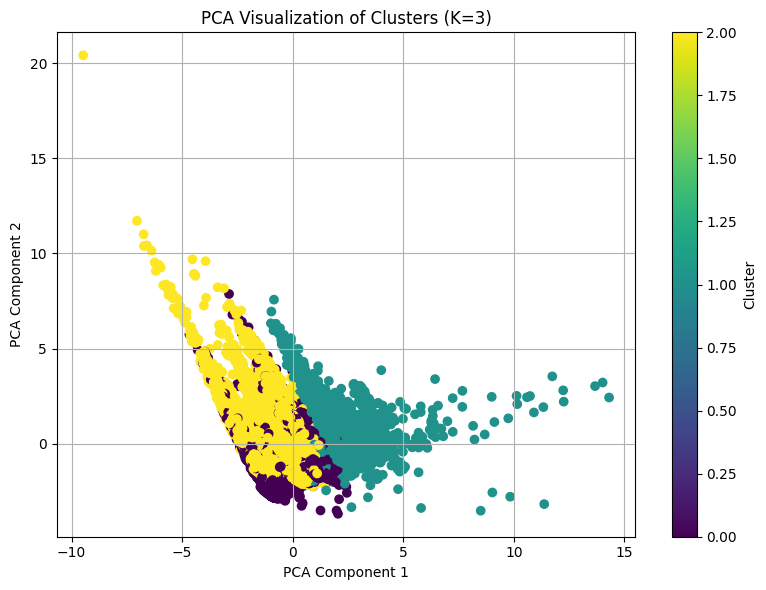

In [17]:
from sklearn.decomposition import PCA

# PCA 2 deminsion visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(df_standard.drop('cluster', axis=1))

# present
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df_standard['cluster'], cmap='viridis')
plt.title('PCA Visualization of Clusters (K=3)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()

# Modeling

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
from scipy.stats import randint

In [19]:
# seperate feature/target
X = df_standard.drop('cluster', axis=1)
y = df_standard['cluster']

print(f"Features (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")
print(f"Target class distribution:\n{y.value_counts()}")

Features (X) shape: (48895, 16)
Target (y) shape: (48895,)
Target class distribution:
cluster
0    20035
2    15400
1    13460
Name: count, dtype: int64


In [20]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTrain set shape for RandomizedSearchCV: {X_train.shape}, {y_train.shape}")
print(f"Test set shape for final evaluation: {X_test.shape}, {y_test.shape}")


Train set shape for RandomizedSearchCV: (39116, 16), (39116,)
Test set shape for final evaluation: (9779, 16), (9779,)


In [21]:
from sklearn.tree import DecisionTreeClassifier

# Decision Tree 모델 정의 및 학습
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

# 예측
y_pred_dt = dt_model.predict(X_test)

# 평가
print("\n--- Decision Tree Classifier Evaluation ---")
print("Test Accuracy (Decision Tree):", accuracy_score(y_test, y_pred_dt))
print("\nClassification Report:\n", classification_report(y_test, y_pred_dt))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))



--- Decision Tree Classifier Evaluation ---
Test Accuracy (Decision Tree): 0.9976480212700685

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4007
           1       1.00      1.00      1.00      2692
           2       1.00      1.00      1.00      3080

    accuracy                           1.00      9779
   macro avg       1.00      1.00      1.00      9779
weighted avg       1.00      1.00      1.00      9779


Confusion Matrix:
 [[4005    1    1]
 [   0 2682   10]
 [   1   10 3069]]


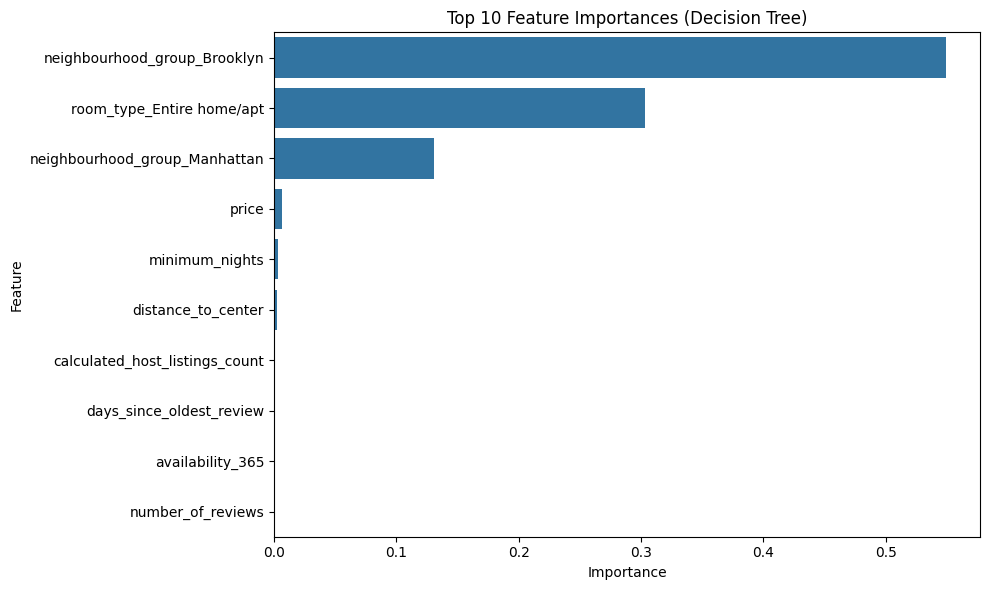

In [22]:
# Feature importance 시각화
dt_feature_importances = pd.Series(dt_model.feature_importances_, index=X.columns)
dt_sorted_importances = dt_feature_importances.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=dt_sorted_importances.head(10).values, y=dt_sorted_importances.head(10).index)
plt.title('Top 10 Feature Importances (Decision Tree)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

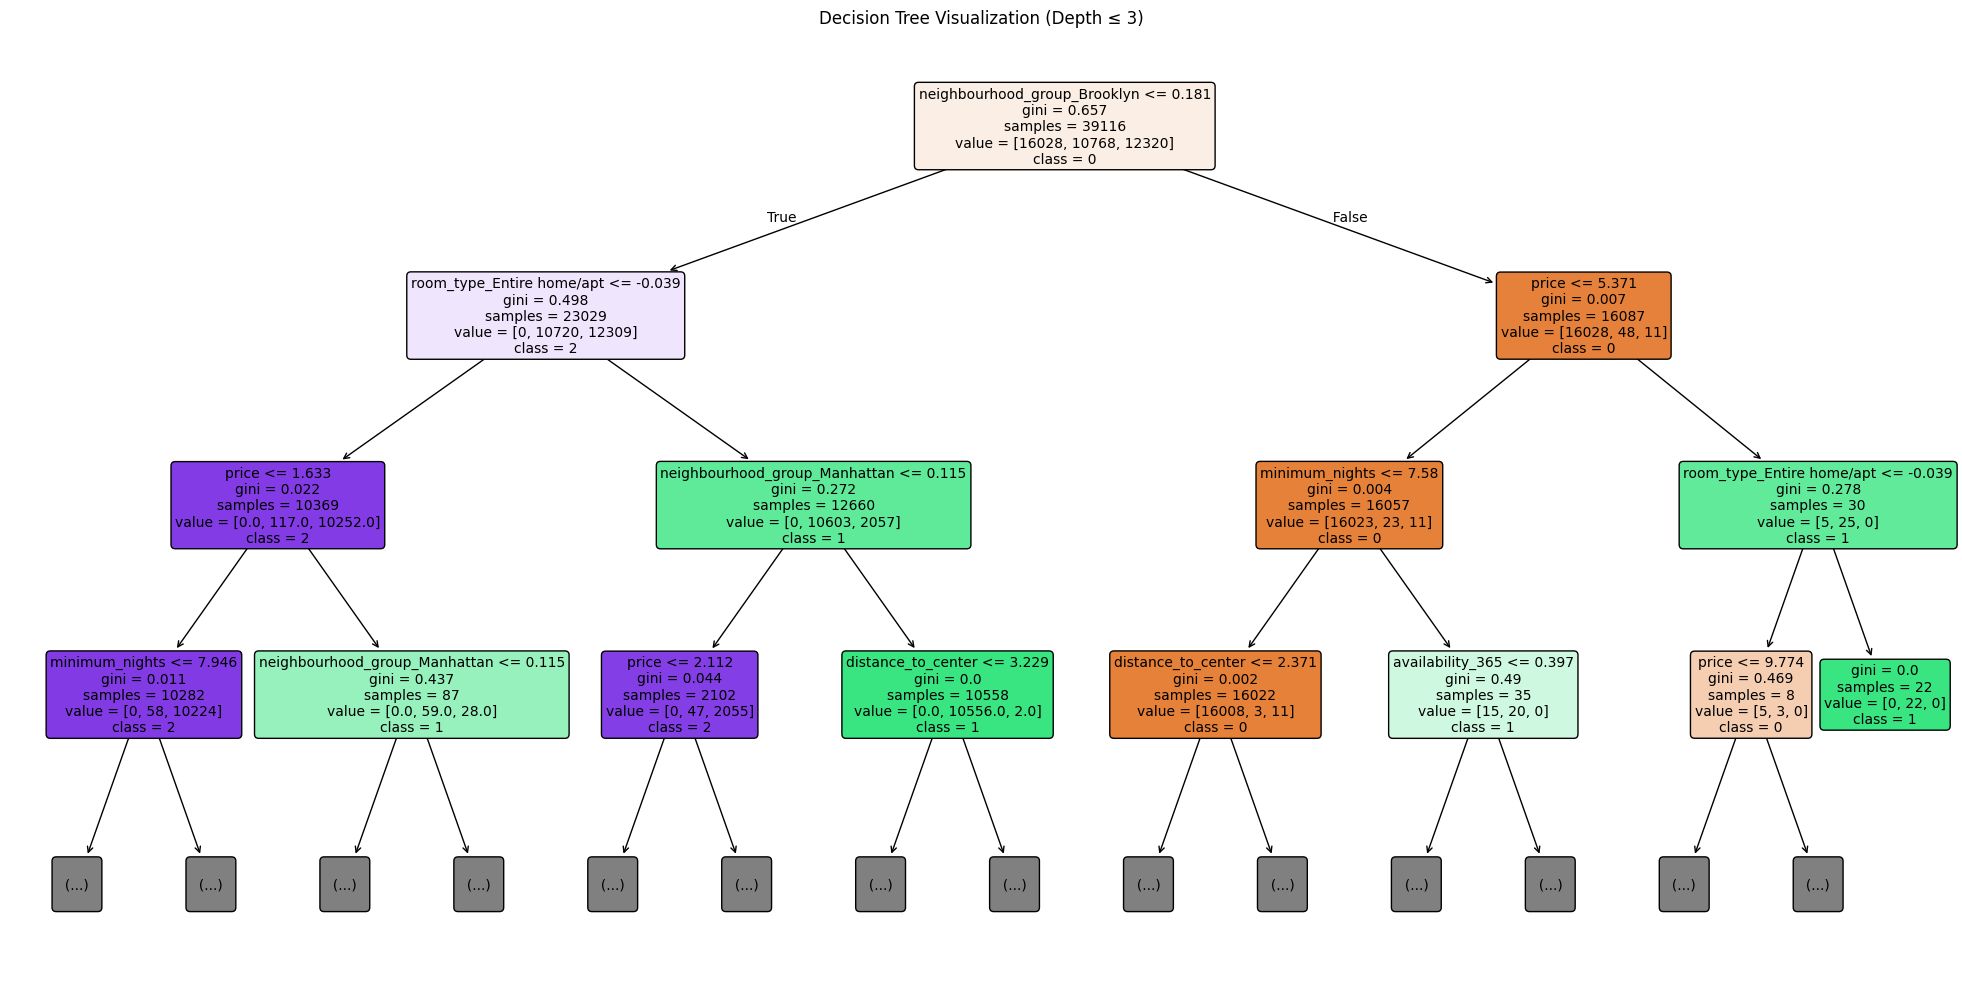

In [23]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(
    dt_model,
    feature_names=X.columns,
    class_names=[str(label) for label in dt_model.classes_],
    filled=True,
    rounded=True,
    fontsize=10,
    max_depth=3  # 너무 복잡하지 않게 보기 좋게 3단계까지만 시각화
)
plt.title("Decision Tree Visualization (Depth ≤ 3)")
plt.tight_layout()
plt.show()


# Evaluation

In [24]:
print("\n--- Random Forest Classifier with RandomizedSearchCV ---")

# initializing model
rf_model = RandomForestClassifier(random_state=42)


--- Random Forest Classifier with RandomizedSearchCV ---


In [25]:
# 3. define hyperparameter exploration range
param_distributions = {
    'n_estimators': randint(100, 500),
    'max_features': ['sqrt', 'log2', None],
    'max_depth': randint(10, 100),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'bootstrap': [True, False]
}

In [26]:
# generating RandomizedSearchCV object
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_distributions,
    n_iter=50,
    cv=skf,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1,
    verbose=2
)

In [27]:
# training model
print("\nStarting RandomizedSearchCV...")
random_search.fit(X_train, y_train)
print("RandomizedSearchCV finished.")


Starting RandomizedSearchCV...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
RandomizedSearchCV finished.


In [28]:
# 6. find best model
print("\n--- Best Parameters and Score ---")
print("Best parameters found: ", random_search.best_params_)
print("Best cross-validation accuracy: {:.4f}".format(random_search.best_score_))

best_rf_model = random_search.best_estimator_

print("\n--- Final Evaluation on Test Set with Best Model ---")
y_pred_final = best_rf_model.predict(X_test)

print("Test Accuracy:", accuracy_score(y_test, y_pred_final))
print("\nClassification Report:\n", classification_report(y_test, y_pred_final))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_final))

print("\n--- Feature Importances from Best Random Forest Model ---")
feature_importances = pd.Series(best_rf_model.feature_importances_, index=X.columns)
sorted_importances = feature_importances.sort_values(ascending=False)
print(sorted_importances.head(10))


--- Best Parameters and Score ---
Best parameters found:  {'bootstrap': False, 'max_depth': 39, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 413}
Best cross-validation accuracy: 0.9979

--- Final Evaluation on Test Set with Best Model ---
Test Accuracy: 0.9978525411596277

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4007
           1       1.00      0.99      1.00      2692
           2       1.00      1.00      1.00      3080

    accuracy                           1.00      9779
   macro avg       1.00      1.00      1.00      9779
weighted avg       1.00      1.00      1.00      9779


Confusion Matrix:
 [[4007    0    0]
 [   2 2678   12]
 [   1    6 3073]]

--- Feature Importances from Best Random Forest Model ---
neighbourhood_group_Brooklyn     0.379714
neighbourhood_group_Manhattan    0.217274
room_type_Entire home/apt        0.128275
room_type_Private 

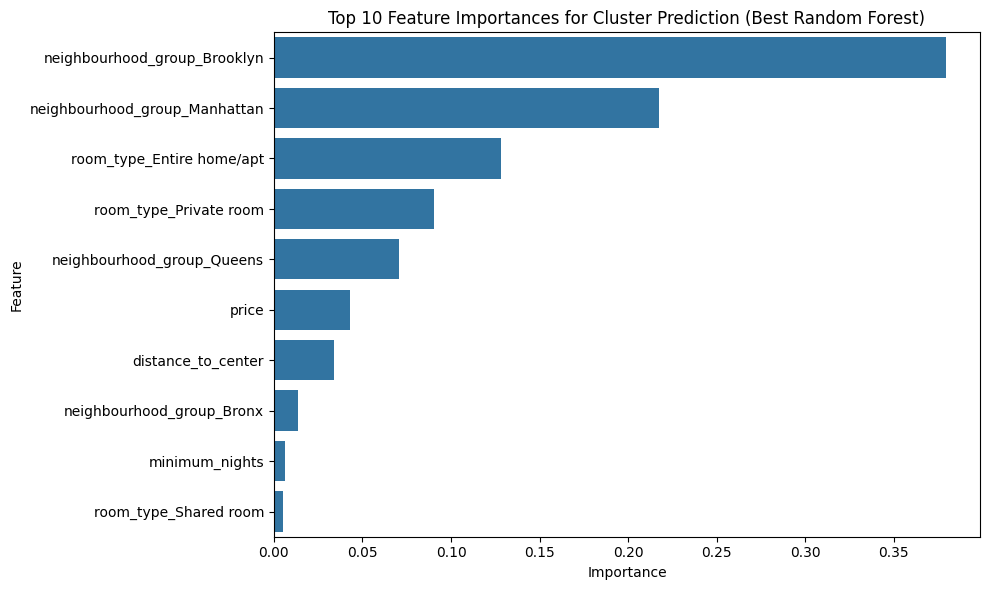

In [29]:
# visualizing feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_importances.head(10).values, y=sorted_importances.head(10).index)
plt.title('Top 10 Feature Importances for Cluster Prediction (Best Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [30]:
print("\n--- 모델 비교 요약 ---")
acc_dt = accuracy_score(y_test, y_pred_dt)
acc_rf = accuracy_score(y_test, y_pred_final)

print(f"Decision Tree Accuracy: {acc_dt:.4f}")
print(f"Random Forest Accuracy: {acc_rf:.4f}")



--- 모델 비교 요약 ---
Decision Tree Accuracy: 0.9976
Random Forest Accuracy: 0.9979



--- ROC Curve (One-vs-Rest) ---


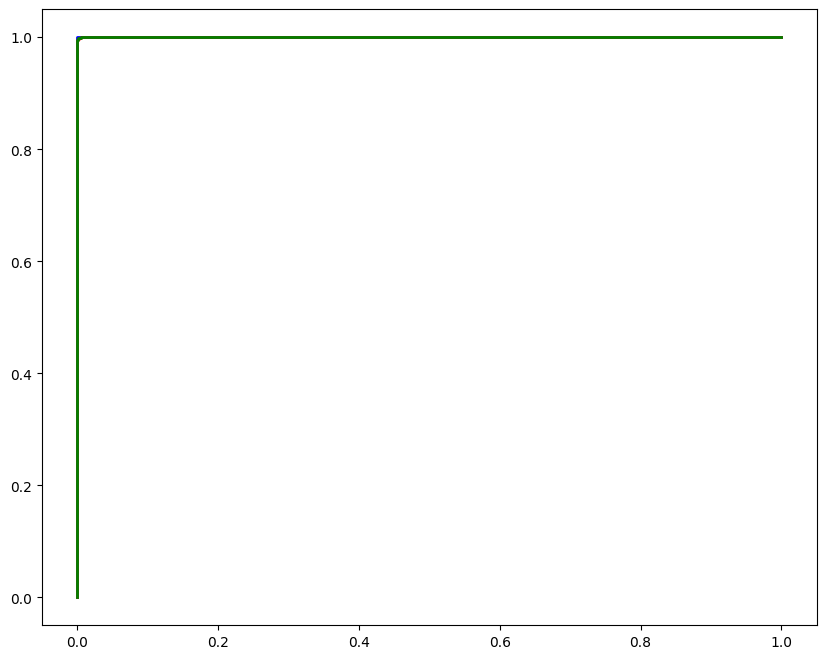

In [31]:
# --- ROC Curve Plotting ---
print("\n--- ROC Curve (One-vs-Rest) ---")

# 1. Get prediction probabilities
y_proba = best_rf_model.predict_proba(X_test)

# 2. Binarize the true labels for multi-class ROC
lb = LabelBinarizer()
y_test_binarized = lb.fit_transform(y_test)

# 3. Plot ROC curve for each class
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green'] # Assuming 3 classes (0, 1, 2)

for i, class_label in enumerate(lb.classes_):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i], lw=2,
             label=f'ROC curve for class {class_label} (area = {roc_auc:.2f})')

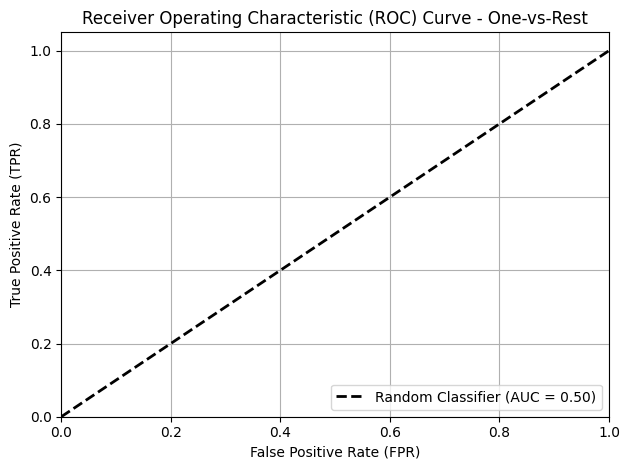

In [32]:
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve - One-vs-Rest')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()